## 0 - Introduction  

### Tutorial purpose
To give you a clear overview of a basic machine learning workflow and to introduce you to the two (arguably) most fundamental classification methods: logistic regression and k-nearest neighbors.

### Learning outcomes  

After finishing this tutorial, you will be able to,  

1. Understand the basic workflow of a machine learning based classification application;
2. Implement a basic classification workflow using open source software;
3. Interpret the results of a basic classification application.

### Tutorial contents
The tutorial will cover the following topics with relevant R codes:

1. Data processing;
2. Model building  
  - K-nearest neighbors;  
  - Random forests;  
  - Confusion matrix;  
3. Cross-validation;  
4. Model selection;  
5. Binary and multiclass classification;  

### About the data sets  
The data set is a snapshot by Landsat-8 OLI of Asheville, North Carolina taken from Landsat 8. The reference data we are using is the Cropland Data Layer (CDL) data from UDSA. It provides the land cover/land use types of each pixel for the same region. There is also a comma-separated values (CSV) file contains the set of random samples within the region with reference CDL land cover information and corresponding reflectance values for model training and evaluation. 

Check out the following links for more information:  

[Landsat-8 OLI data](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)

[USDA Cropland Data Layer (CDL)](https://nassgeodata.gmu.edu/CropScape/)

## 1 - Data processing  

Before we starts to read in the data, we need to load our data into the Google cloud space. To do so, we will clone the data within the GitHub repository using the command below.

In [ ]:
! git clone  https://github.com/geo-yrao/esip-ml-tutorials/

Now let's check if all the data files listed under the directory *./esip-ml-tutorials/classification/*, which is where we are operating from.

In [ ]:
# Define the path and names of our data files.
path_data_dir = "./esip-ml-tutorials/classification/"

# To run a bash command in any notebook cell, simply add an ! before the
# command. For instance, the command to navigate from your current directory
# to a subdirectory named "data" one would execute the following line:
#
# !cd data/
#
# Here, let's see if we can view the directory containing our data.
! ls $path_data_dir

CDL_2017.tif					       label_information.txt
ESIP-Machine-Learning-Tutorial-Classification-R.ipynb  NC_L8_GroundTruth.csv
ESIP-Machine-Learning-tutorial-classification.Rmd      README.md


### 1.1 - Data ingest 

First thing first, we will read in the data for this notebook. The data file [*NC_L8_GroundTruth.csv*](https://github.com/geo-yrao/esip-ml-tutorials/blob/master/classification/NC_L8_GroundTruth.csv) contains sampled pixels in western North Carolina. The data contains both the multispectral reflectance from Landsat-8 OLI data and corresponding land cover types from USGS Cropland Data Layer (CDL).

The file [*CDL_2017.tif*](https://github.com/geo-yrao/esip-ml-tutorials/blob/master/classification/CDL_2017.tif) contains the USGS Cropland Data Layer (CDL) data for the region of 2017. To help us better understand land cover classification looks like, let's look at the images using the [Python Imaging Library (PIL)](https://en.wikipedia.org/wiki/Python_Imaging_Library).

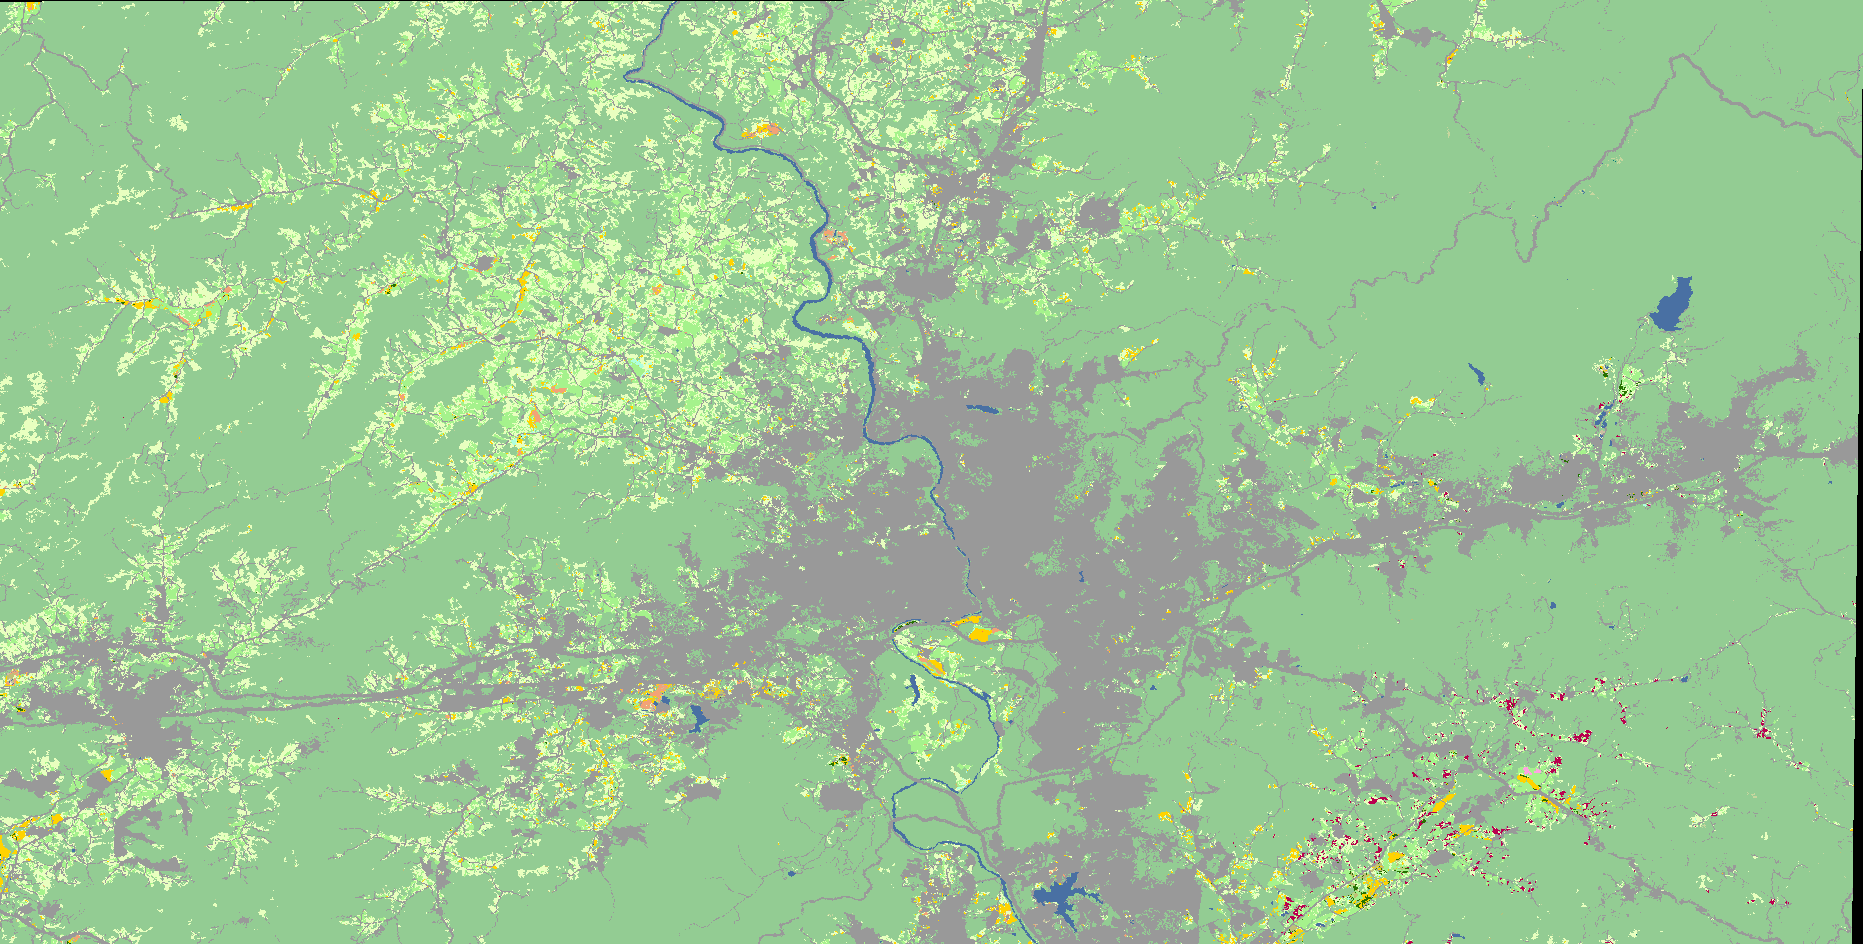

In [ ]:
# Load PIL's Image class.
from PIL import Image

# Import the image.
image = Image.open(path_data_dir+"CDL_2017.tif")

# Display the image.
image

In [ ]:
print("Image size in pixels:", image.size)

Image size in pixels: (1863, 944)


We now see there are multiple classes involved in this image since it want to distinguish different vegetation types (including different forest types and various crop types) for western North Carolina. More specifically, this is Asheville area. For this tutorial, we focus on the prepared random sample files in the comma-separated values (CSV) format and let's get the data in. 

In [ ]:
## We will now use the popular Python library Pandas to import the file into a pandas.Dataframe object. 
## On the surface, a dataframe is Python's version of an Excel spreadsheet. But because a vast suite of methods 
## lies beneath them, dataframes are quite a powerful tool for exploring data sets.

# Import Pandas and assign it the shorter alias "pd" to save time and space when calling it in the
# following code cells.
import pandas as pd

In [ ]:
# Adding a question mark in front of any variable/method/object while using the
# Python command line or IPython will cause that entity's documentation to be
# printed for the user.
?pd.read_csv

In [ ]:
# Import the data, using the first column as the dataframe's index.
AVLData = pd.read_csv(path_data_dir + "NC_L8_GroundTruth.csv", index_col=None)

#Let's take a look at the dimension of this data.
print(AVLData.shape)

(2375, 10)


From this output of the dimension information, we have 2,375 samples in the area.

### 1.2 Data exploration  

Our data contains the location (_"Latitude", "Longitude"_), land cover type (_"Class"_), and reflectance of six Landsat-8 OLI channels (_"B1"~"B6"_). Let's first check how the data frame looks like for their first 10 rows.

In [ ]:
# Take a look at the first 10 rows of the dataframe.
AVLData.head(10)

,Unnamed: 0,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
0,1,35.514769,-82.680451,0,127,150,550,226,3609,1441
1,2,35.753979,-82.520432,0,81,115,426,170,2913,1110
2,3,35.710635,-82.305661,0,156,220,538,477,2492,2077
3,4,35.512814,-82.413861,0,245,280,663,507,2732,1531
4,5,35.520636,-82.853181,0,148,181,534,265,3320,1457
5,6,35.619057,-82.807880,0,202,289,651,522,3047,2251
6,7,35.554203,-82.504789,0,208,250,521,408,2905,1738
7,8,35.560395,-82.300773,0,60,91,486,184,3431,1342
8,9,35.545730,-82.505115,0,122,155,463,219,3385,1264
9,10,35.649366,-82.479694,0,207,260,603,441,3205,1801


As some of you may have noticed, this dataframe is 0-indexed, in accordance with Python's standard indexing convention. So, to keep with the Pythonic convention, let's dropt the first column of the dataframe, which was the original row-numbering index, as found in the CSV.

In [ ]:
# Delete the column named "Unnamed: 0", which were the row indices in the CSV.
AVLData = AVLData.drop(labels=["Unnamed: 0"], axis="columns")

# Check the dataset again
AVLData.head()

,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
0,35.514769,-82.680451,0,127,150,550,226,3609,1441
1,35.753979,-82.520432,0,81,115,426,170,2913,1110
2,35.710635,-82.305661,0,156,220,538,477,2492,2077
3,35.512814,-82.413861,0,245,280,663,507,2732,1531
4,35.520636,-82.853181,0,148,181,534,265,3320,1457


The following table present the information about the six [OLI chanles](https://en.wikipedia.org/wiki/Landsat_8) included in the data. The reflectance data can provide unique information to charaterize different land cover types.

| Channel No. | Channel Name | Wavelength |
|-:|-:|:-:|
|B1|Coastal/Areasol|0.433 – 0.453 μm| 
|B2|Blue|0.450 – 0.515 μm|
|B3|Green|0.525 – 0.600 μm|
|B4|Red|0.630 – 0.680 μm|
|B5|Near Infrared|0.845 – 0.885 μm|
|B6|Short Wavelength Infrared|1.560 – 1.660 μm|  

### 1.3 - Viewing class historgram  

We want to understand how many samples belong to each class. In our data, there are five different classes as listed in the table below. This information can be found in the file [_label_information.txt_]((https://github.com/geo-yrao/esip-ml-tutorials/blob/master/classification/label_information.txt)).  

| Class No. | Land Cover Type |
|-:|-:|
|0|Forest| 
|1|Corn|
|2|Soy|
|3|Development/Urban|
|4|Water| 

Here, we create a histogram to examing the histogram of land cover types in the data. The purpose of examing the histogram is to make sure that we have a balanced sample of data. This will be important for later machine learning model training.   

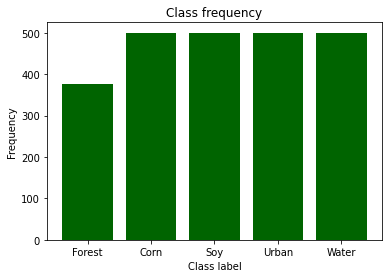

In [ ]:
## Here, we will use Matplotlib, Python's most popular plotting library, 
## to gain an understanding of the distribution of the classes.

# Import matplotlib's pyplot module for quick and easy plotting.
import matplotlib.pyplot as plt
# Import numpy for math/numerical analysis library.
import numpy as np

# Get the class as the outcome variable for our later classification modeling
y = AVLData.values[:, 2] # Target. The "Class" column in the data frame.

# Get the frequency of each class labels
unique, counts = np.unique(y, return_counts=True)

# This is the list of class names for the histogram
class_labels_list = ["Forest", "Corn", "Soy", "Urban", "Water"]

# Define a list of attractive colors to use in the notebook's data viz.
# class_colors_list = ["darkgreen", "gold", "salmon", "firebrick", "royalblue"]

# Use Matplotlib's Pyplot module to quickly inspect the class distributions.
_ = plt.bar(class_labels_list, counts, color="darkgreen")

# Use Pyplot to add a title and labels to the x- and y-axises.
plt.title("Class frequency")
plt.xlabel("Class label")
plt.ylabel("Frequency")

# Now that we're done modifying the plot, tell Pyplot to display it.
plt.show()


As you can see, the data is overall well balanced across different classes except for forest (*Class == 0*). 


### 1.4 - Feature space  

Before we dive into model training, we can examine the features (i.e., reflectance) that will be used for building the classifier. We use Channel 2 (_B2_) and 5 (_B5_) as an example. Please consider modify the code below to explore different feature combinations.  


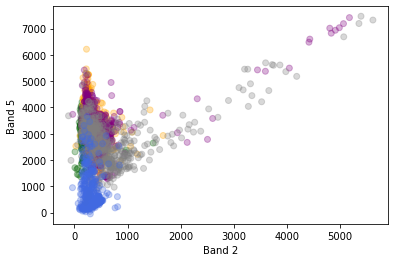

In [ ]:
X = AVLData.values[:, 3:]  # Data. The six L8 channels in the dataframe.
colormap = np.array(["darkgreen", "orange", "purple", "grey25", "royalblue"])

# Define the bands used for the scatter plot
first_band = 1
second_band = 4

# Add some of the plotting aesthetic parameters that you might want to play around with.
alpha = 0.3

# define color for each class lables
colormap = np.array(["darkgreen", "orange", "purple", "grey", "royalblue"])
cpt = colormap[np.int_(y)]

# Initialize a new matplotlib figure and its axes object.
fig, ax = plt.subplots()

# Creating the scatter plot with multiple class
scatter = ax.scatter(X[:,first_band], X[:,second_band], alpha=alpha, c=colormap[np.int_(y)])

# Add labels to the x- and y-axes. The code is formatted so the labels will change
# if you modify which bands you're plotting.
ax.set_xlabel(f"Band {first_band+1}")
ax.set_ylabel(f"Band {second_band+1}")

fig.show()


It looks like the forest, corn, and soy can be separated from urban and water, while it might be diffcult to distinguish forest, soy, and corn from each other. This is reasonable since all vegetation share similar spectral signatures that are unique comparing to water and urban classes. But the spectral differences between different vegetation types could be small in certain feature combinations. In the next code chunk, please try to modify the code to see other feature combinations (e.g., B2 v.s. B6).  


In [ ]:
### Consider how you can modify the code from last chunk and create a new scatter plot between B2 and B6;
### What does the feature space look like? Can you distinguish different classes here?



### 1.5 - Simpilying to a binary classification example  

As our first classifier, let's focus on a binary classifier example. So we first keep samples of forests (*Class == 0*) and water (*Class == 4*). We will implement the multiclass classification later.

In [ ]:
# Find the array indices for the forest and water samples in the dataset.
indices_forest = np.where(y==0)
indices_water = np.where(y==4)

# Create a binary classification data set of the data and the target for corn vs. urban pixels.
X_bin = np.concatenate((X[indices_forest], X[indices_water]))
y_bin = np.concatenate((y[indices_forest], y[indices_water]))

# Check on the dimensions for sanity.
print(X_bin.shape)

(875, 6)


## 2 - Model building 

Starting from this section, we are working on developing classifiers that can use the Landsat 8 reflectance data to distinguish different class types as presented in our sample data.

### 2.1 - K-nearest neighbor (k-NN)

[**K-nearest neighbor (k-NN)**](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) is probably one of the most intuitive classification models. **Most machine learning classifiers can, in their most trivial cases, be reduced to either a form of logistic regression or a form of KNN or some combination thereof.**  

k-NN assumes that the class of a given unknow data point is determined by the classes of its closest "neighbors" in the feature space. There is one hyperparameter that need to be determined by us, which is the number of neighbors (__*k*__) used to determine the class of any data points.  

There are different variations of k-NN model which are developed to improve its performance for different challenging tasks. But here we will use the classic k-NN model.   

To learn more about these methods, check out the [User Guide from Scikit-Learn on Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html).  

There is only one model hyperparameter need to be specified to train a k-NN model. To start with the model, we will simply use _**k = 9**_ for our first k-NN model without any cross-validation. 
 

In [ ]:
## First, import scikit learn into the notebook
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Binarize the forest and water sample labels.  We do this step because sklearn's
# classifiers will assume that we're dealing with a multiclass classification
# problem if they see any labels that aren't 0 and 1.
lb = LabelBinarizer()
y_binary = lb.fit_transform(y_bin.tolist())

## We are spliting our data set into training and testing sets based on a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_binary, test_size=0.2, random_state=0)

# Initialize a KNN classifier object. Later, we'll train it and then have it predict the
# classes of withheld testing samples.
knn_classifier = KNeighborsClassifier(n_neighbors=9)

# let's train the model with k=9
knn_classifier.fit(X_train, y_train.ravel())

# Have the newly trained classifier predict the classes of the withheld testing data.
knn_predicted = knn_classifier.predict(X_test)



### 2.2 - Generate confusion matrix  

Now we have our binary k-NN classifier. We need to evaluate how the model performs based on our data. We can tabulate the predicted classes and the reference classes into a confusion matrix.  

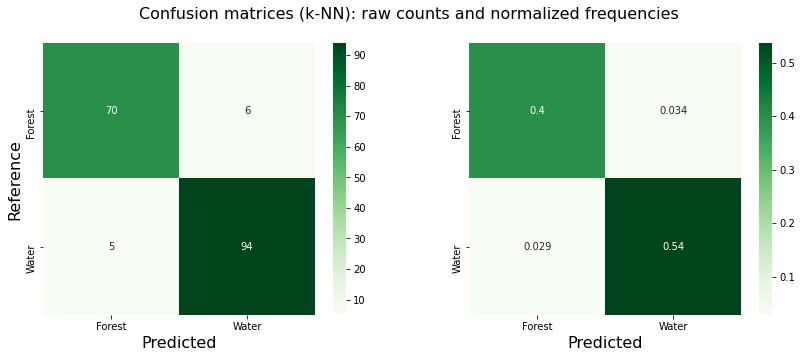

In [ ]:
# Import the plotting library Seaborn (it makes pretty data viz easy) and
# Scikit-Learn's confusion_matrix object so we can plot the confusion matrices.
import seaborn
from sklearn.metrics import confusion_matrix

## Calculate the confusion matrix and normalized confusion matrix
knnMatrix = confusion_matrix(y_test.ravel(), knn_predicted.ravel())
knnMatrix_normalized = knnMatrix/knnMatrix.sum()

# Initialize figure, axes for the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    knnMatrix, cmap="Greens", annot=knnMatrix, square=True, cbar=True,
    xticklabels=["Forest","Water"], yticklabels=["Forest","Water"],
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("Reference", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    knnMatrix_normalized, cmap="Greens", annot=True, square=True,
    xticklabels=["Forest","Water"], yticklabels=["Forest","Water"],
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrices (k-NN): raw counts and normalized frequencies", fontsize=16)

# Display the figure.
fig.show()

With the confusion matrix, we can calculate many different quantitative indicators to assess the performance of our model, including _accuracy_, _precision_, _recall_, and _F1 score_. 

In [ ]:
# Import the classification_report function from sklearn.metrics.
from sklearn.metrics import classification_report

print(
    classification_report(y_test.ravel(), knn_predicted.ravel(),
                          target_names=["Forest", "Water"])
)

              precision    recall  f1-score   support

      Forest       0.93      0.92      0.93        76
       Water       0.94      0.95      0.94        99

    accuracy                           0.94       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175



From the classifcation metrix report, our k-NN model has done a decent job on classifying labels into forest or water with an overall accuracy of 0.94.  


### 2.3 - Random forest  

There are more sophiscated models that we can use to address more sophisicated classification problems. Here, we choose to introduce [random forest](https://en.wikipedia.org/wiki/Random_forest) model because of its robust performance in many applications. The random forest is an ensemble learning model by creating a suite of decision trees at training time and outputting the class that is the majority of the classes from each individual tree for classification problem. The fundamental idea of random forest  model is that the **collective power of multiple "weak" models can outperform any individual "strong" model**. It can address overfitting issue comparing to the regular decision tree model.  

Similar with k-NN, there are different flavors of random forest model. We are using the classic random forest model with *scikit-learn* package in Python (i.e., [_RandomForestClassifier_](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees). As the model gets more complicated, we have more to consider about the model structure, such as, how many variables we want to have as input for each tree (*max_features*), number of trees (*n_estimator*), the depth of a decision tree (*max_depth*, *min_sample_split*, *min_sample_leaf*). These could all have potential impact on our final model outcomes. 



In [ ]:
# Import the random forest classifier from sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier

## For consistency with our R notebook, we set the *n_estimator=500* as the 
## default number of trees.

## To build our first random forest model, we fix 
##     max_features = 4; min_sample_leaf = 1
## to be consistent with R notebook

# Now we create a random forest classifier.
rf_Classifier = RandomForestClassifier(n_estimators=500, max_depth=None,
                                      max_features=4, min_samples_leaf=1,
                                      min_samples_split=2, random_state=0)

# Using the training set, we can fit our model now
rf_Classifier.fit(X_train, y_train.ravel())

# Have the newly trained classifier predict the classes of the withheld testing data.
rf_predicted = rf_Classifier.predict(X_test)


Similarly, we can generate the confusion matrix as well as the model performance indicators (i.e., *accuracy*, *precision*, *recall*, and *F1*). This will inform us how the model works overall when it is tested using the withheld data.  


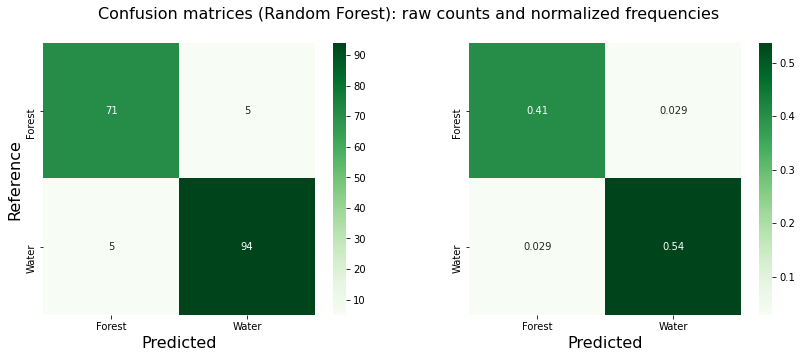

In [ ]:
## Calculate the confusion matrix and normalized confusion matrix
rfMatrix = confusion_matrix(y_test.ravel(), rf_predicted.ravel())
rfMatrix_normalized = rfMatrix/rfMatrix.sum()

# Initialize figure, axes for the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    rfMatrix, cmap="Greens", annot=rfMatrix, square=True, cbar=True,
    xticklabels=["Forest","Water"], yticklabels=["Forest","Water"],
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("Reference", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    rfMatrix_normalized, cmap="Greens", annot=True, square=True,
    xticklabels=["Forest","Water"], yticklabels=["Forest","Water"],
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrices (Random Forest): raw counts and normalized frequencies", fontsize=16)

# Display the figure.
fig.show()

In [ ]:
## reporting the indicators for the random forest classifier
print(
    classification_report(y_test.ravel(), rf_predicted.ravel(),
                          target_names=["Forest", "Water"])
)

              precision    recall  f1-score   support

      Forest       0.93      0.93      0.93        76
       Water       0.95      0.95      0.95        99

    accuracy                           0.94       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175



## 3- Cross validation 

To explore the optimum combination of the model hyperparameters, we typically uses the cross validation (CV) strategy. There are different type of cross validation strategy, such as, k-fold cross validation, leave-one-out cross validation, repeated cross validation. More information can be found in this [well written article about the importance of CV for machine learning](https://www.digitalvidya.com/blog/cross-validation-in-machine-learning/).  

The most commonly used CV strategy is usually [k-fold CV](https://machinelearningmastery.com/k-fold-cross-validation/). But it still depends on the data that have for your problem. If you are using time series data, your cross validation strategy will be different since you want to account for the tempooral autocorrelation within your data. Same idea applies when your data have strong spatial auto correlation. But today, let's assume that k-fold CV can solve our problem. 


### 3.1 - Methods of data splitting for cross-validation: variants of k-fold splitting and their implications

For classification problem, we really want to make sure that the training sample can well represent the "reality". It means that we don't want to have any classes under- or over-represented in both training and validation data set while we are trying to decide the optimum model hyperparameters. Both situations could lead to large bias or uncertainty when the model is applied to new independant dats in the future.  

To further explain how different implementation of k-fold cross validation may affect the data distribution. Let's do some exercise here. The two methods we are comparing is just [*random k-fold* and *stratified k-fold*](https://scikit-learn.org/stable/modules/cross_validation.html).  

A quick way to separate these two methods is that random k-fold do not consider the labels of our data while stratified k-fold take the propotion of each label into consideration while perform data splitting.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


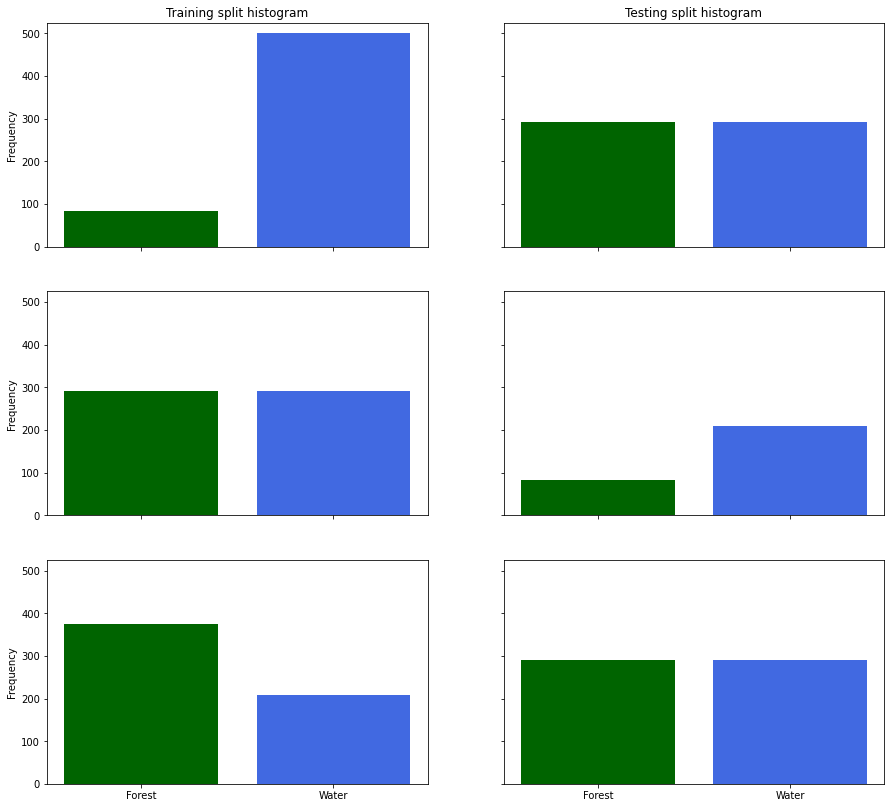

In [ ]:
## Import the data spliting function from sklearn.model_selection
from sklearn.model_selection import KFold, StratifiedKFold

## Initialize a k-fold cross-validation generator to split our data sets for us.
kfold_generator = KFold(n_splits=3, random_state=7)

# Show histograms of class distributions across the splits
labels_list = ["Forest", "Water"]
colors_list = ["darkgreen", "royalblue"]

# Here, instead of using Pyplot's high-level commands, we're going to produce a 
# matplotlib figure with multiple subplots. These subplots are represented by 
# "axes" objects.
# Creating a panel of plots with three rows and two columns.
fig, ax = plt.subplots(3, 2, figsize=(15, 14), sharex=True, sharey=True)

# Iterate through the splits and plot the classes' distributions.
for axes_row_idx, (splits_train, splits_test) in enumerate(kfold_generator.split(X_bin)):
    
    # Get this split's training and testing labels.
    y_trn = y_bin[splits_train]
    y_tst = y_bin[splits_test]

    # Get the counts for each of the unique class labels so we can plot their distribution.
    _, counts_train = np.unique(y_trn, return_counts=True)
    _, counts_test  = np.unique(y_tst, return_counts=True)

    # Plot the training splits' distributions in the left-hand column and the 
    # testing splits' distributions in the right-hand column. The ";" at the end
    # of the following two lines is to suppress some returned output.
    ax[axes_row_idx][0].bar(labels_list, counts_train, color=colors_list);
    ax[axes_row_idx][1].bar(labels_list, counts_test , color=colors_list);

    # Add a label to the y axis of the left column's subplot.
    ax[axes_row_idx][0].set_ylabel("Frequency")

# Add titles over the left and right columns.
ax[0][0].set_title("Training split histogram")    
ax[0][1].set_title("Testing split histogram")

# Nicely ask the computer to show us the plots.
fig.show()


Notice how imbalanced the classes are in both the training and testing splits. If we were doing many, many more splits, and there weren't a pre-existing class imbalance, then we wouldn't worry as much about this imbalance. But, it has the capacity of interfering with our classifiers' abilities to learn if it has significantly imbalanced sample distributions.

With this problem in mind, let's look at using a stratified k-fold splitting approach. A stratified splitter takes into account the class distributions and accounts for them when randomly shuffling and splitting the samples.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


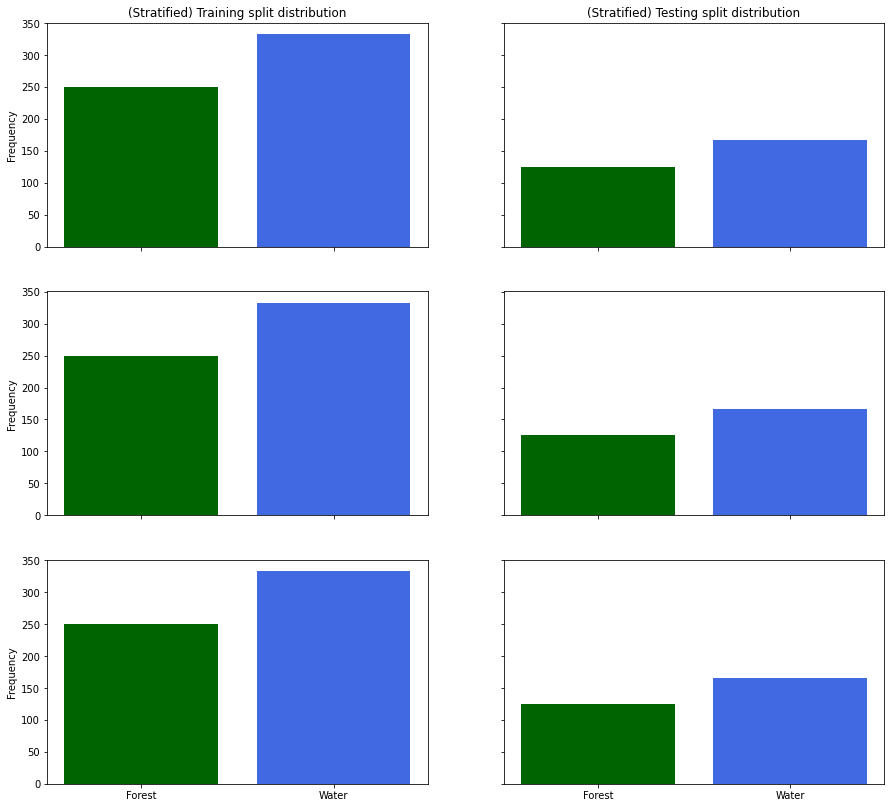

In [ ]:
# Initialize a 3-fold stratified splits generator.
stratified_kfold_generator = StratifiedKFold(n_splits=3, random_state=7)

# Iterate through the splits and plot them.
fig, ax = plt.subplots(3, 2, figsize=(15, 14), sharex=True, sharey=True)
for row_idx, (splits_train, splits_test) in\
    enumerate(stratified_kfold_generator.split(X_bin, y_bin)):
    
    # Get the training and testing labels.
    y_trn = y_bin[splits_train]
    y_tst = y_bin[splits_test]

    # Get the counts for each of the unique class labels so we can plot their distribution.
    _, counts_train = np.unique(y_trn, return_counts=True)
    _, counts_test = np.unique(y_tst, return_counts=True)

    # Plot this split's class distributions.
    ax[row_idx][0].bar(labels_list, counts_train, color=colors_list);
    ax[row_idx][1].bar(labels_list, counts_test, color=colors_list);

    # Add a label to the shared y-axis.  
    ax[row_idx][0].set_ylabel("Frequency")

# Add separate titles to the two subplots.
ax[0][0].set_title("(Stratified) Training split distribution")    
ax[0][1].set_title("(Stratified) Testing split distribution")

fig.show()

As shown in this comparison, the stratified k-fold splitting demonstrate a strong advantage to avoid extreme imbalanced data for model training and development.

### 3.2 Cross validation for hyperparameter tuning

We can use a stratified 10-fold CV to find the optimum hyperparameters for our two classifiers (i.e., k-NN and random forest) to see if the model performance could be further improved. Let's start with k-NN to find out the best number of neighbors (*k*) for the model.

The idea is to repeat the model traininig 10 times using a subset (9/10) of the training data set with different value of *k*. The average value of the model performance metrices from these 10 iteration of model training is used to choose which hyperparameter (i.e., *k*) performs best.

In [ ]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid. In this case, it's just a list of all the
# candidate number of neighbors we'll consider.
n_neighbors_list = [1, 3, 5, 7, 9, 11, 13, 15]
param_grid = {"n_neighbors" : n_neighbors_list}

# Initialize a KNN classifier object. 
knn_classifier = KNeighborsClassifier()

# Initialize a stratified 10-fold generator for the cross-validation.
stratified_kfold_generator = StratifiedKFold(n_splits=10, random_state=7)

# Create the grid search object. This object will take the kNN classifier
# and run stratified 10-fold cross-validation for each of the potential
# candidates for k. It will record the averaged accuracy for each k so
# that afterwards we can view how the classifier's accuracy improves or
# worsens with respect to k.
gridsearch_cv_obj = GridSearchCV(
    knn_classifier, 
    param_grid, 
    scoring=make_scorer(accuracy_score), 
    cv=stratified_kfold_generator,
    n_jobs=-1,
  )

# Run the grid search for the optimal number of neighbors, k.
gridsearch_cv_obj.fit(X_train, y_train.ravel());

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


We now have a set of models and its performance based on this stratified 10-fold cross validation. Now, we can plot the model accuracy as a function of *k*. This will assist us selecting the optimum solution.

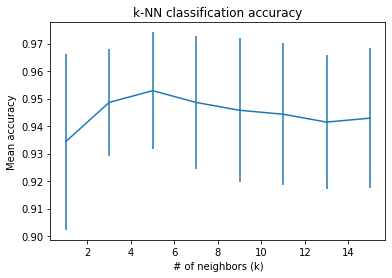

In [ ]:
## Calculating the mean and standard deviation of the accuracy for the model test scores
mean_test_accuracy = gridsearch_cv_obj.cv_results_["mean_test_score"]
std_test_accuracy  = gridsearch_cv_obj.cv_results_["std_test_score"]

## Plotting out the accuracy agiand k
fig, ax = plt.subplots()

ax.errorbar(
    x=n_neighbors_list,
    y=mean_test_accuracy,
    yerr=std_test_accuracy,
    solid_capstyle="round"
)
ax.set(
    xlabel="# of neighbors (k)", 
    ylabel="Mean accuracy", 
    title="k-NN classification accuracy"
);

In [ ]:
# Print the optimal number of neighbors, k.
print("Optimal number of neighbors:", gridsearch_cv_obj.best_params_)
print("Best accuracy:", gridsearch_cv_obj.best_score_)

Optimal number of neighbors: {'n_neighbors': 5}
Best accuracy: 0.9528571428571428


Now, let's try the same thing for our random forest classifier. We have many parameters can be tuned. But let's keep things simple, just modifying two variables -- "*max_features*" and "*min_samples_leaf*". 

In [ ]:
# Set up the parameter grid. In this case, it's just a list of all the
# candidate number of neighbors we'll consider.
tuned_parameters = {'n_estimators': [500], 
                    'max_depth':    [None],
                    'min_samples_split': [2],
                    'random_state': [0],
                    'max_features': [2, 3, 4, 5, 6], 
                    'min_samples_leaf': [1, 3, 5, 7]}

# Initialize a ra classifier object. 
rf_classifier = RandomForestClassifier()

# Create the grid search object. This object will take the kNN classifier
# and run stratified 10-fold cross-validation for each of the potential
# candidates for k. It will record the averaged accuracy for each k so
# that afterwards we can view how the classifier's accuracy improves or
# worsens with respect to k.
gridsearch_cv_obj = GridSearchCV(
    rf_classifier, 
    tuned_parameters, 
    scoring=make_scorer(accuracy_score), 
    cv=stratified_kfold_generator,
    n_jobs=-1,
  )

# Run the grid search for the optimal number of neighbors, k.
gridsearch_cv_obj.fit(X_train, y_train.ravel());

This process might take a while (~ 3-4 mins) since we are doing a more complicated model training for 200 times (10-fold, 5-_max_features_, 4-_min_samples_leaf_).  

Once this process is completed, we will do the same process to evaluated the model performance with the best combination of the parameters.

In [ ]:
## Print best parameter combination
print("Best parameters set found on development set:")
print()
print(gridsearch_cv_obj.best_params_)
print()


Best parameters set found on development set:

{'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 0}



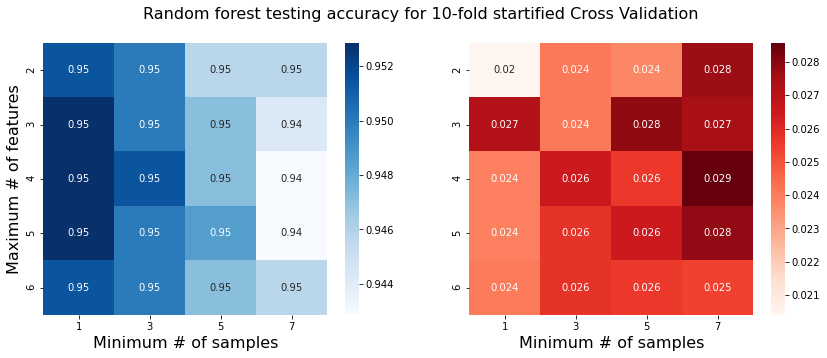

In [ ]:
## Calculating the mean and standard deviation of the accuracy for the model test scores
mean_test_accuracy = gridsearch_cv_obj.cv_results_["mean_test_score"]
stds_test_accuracy  = gridsearch_cv_obj.cv_results_["std_test_score"]

max_features = gridsearch_cv_obj.cv_results_["param_max_features"]
min_samples_leaf = gridsearch_cv_obj.cv_results_["param_min_samples_leaf"]

## rearrange the accuracy data to a 2d array so we can have a heatmap
mean_accuracy_2d = mean_test_accuracy.reshape(5, 4)
stds_accuracy_2d = stds_test_accuracy.reshape(5, 4)
# 5 rows for max_features & 4 columns for min_samples_leaf

## Creating the heatmap for both mean accuracy and standard deviation
# Initialize figure, axes for the accuracy heatmap.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    mean_accuracy_2d, cmap="Blues", annot=True, square=False, cbar=True,
    xticklabels=[1, 3, 5, 7], yticklabels=[2, 3, 4, 5, 6],
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Minimum # of samples", fontsize=16)
ax[0].set_ylabel("Maximum # of features", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    stds_accuracy_2d, cmap="Reds", annot=True, square=False,
    xticklabels=[1, 3, 5, 7], yticklabels=[2, 3, 4, 5, 6],
    ax=ax[1]
)

# Add labels to the x-axis and the y-axis.
ax[1].set_xlabel("Minimum # of samples", fontsize=16)

# Add a title to the figure.
fig.suptitle("Random forest testing accuracy for 10-fold startified Cross Validation", fontsize=16)

# Display the figure.
fig.show()




## 4 - Model selection

Now, we have two binary classification models - a k-NN classifier and a random forest classifier. Given these models, can we make statistical statements about their performance differences, thus leading us to the decision which model shall we use?


Let's put things together by comparing the testing performance of the optimized random forest classifier and k-nearest neighbors classifier throught the confusion matrix.


In [ ]:
# Initialize optimized k-NN classifier object. 
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train.ravel())

# Have the newly trained classifier predict the classes of the withheld testing data.
knn_predicted = knn_classifier.predict(X_test)

## confusion matrix for k-NN
cfKNN = confusion_matrix(y_test, knn_predicted.ravel())
cfKNN_normalized = cfKNN/cfKNN.sum()

# Initialize optimized random forest classifier object. 
rf_classifier = RandomForestClassifier(n_estimators=500, max_depth=None,
                                        min_samples_leaf=1, max_features=3,
                                        min_samples_split=2)
rf_classifier.fit(X_train, y_train.ravel())

# Have the newly trained classifier predict the classes of the withheld testing data.
rf_predicted = rf_classifier.predict(X_test)

## confusion matrix for k-NN
cfRF = confusion_matrix(y_test, rf_predicted.ravel())
cfRF_normalized = cfRF/cfRF.sum()

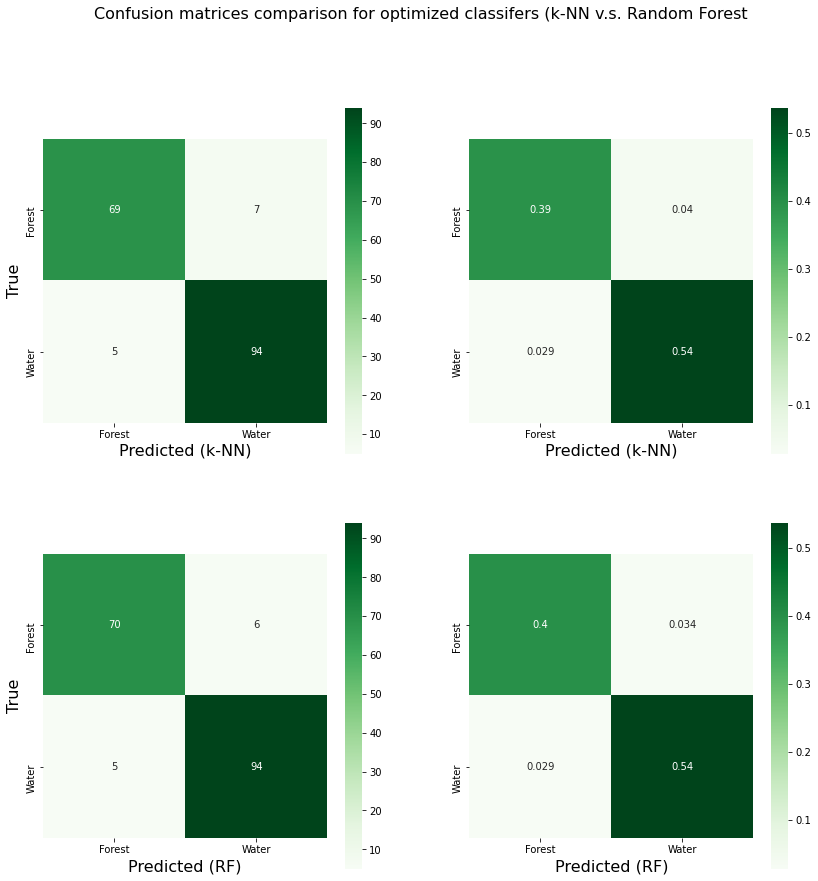

In [ ]:
# Initialize figure, axes for the four confusion matrices.
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    cfKNN, cmap="Greens", annot=cfKNN, square=True, cbar=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[0,0]
)

# Add labels to the x-axis and the y-axis.
ax[0,0].set_xlabel("Predicted (k-NN)", fontsize=16)
ax[0,0].set_ylabel("True", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    cfKNN_normalized, cmap="Greens", annot=True, square=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[0,1]
)

# Add a label to the x-axis.
ax[0,1].set_xlabel("Predicted (k-NN)", fontsize=16)

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    cfRF, cmap="Greens", annot=cfRF, square=True, cbar=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[1,0]
)

# Add labels to the x-axis and the y-axis.
ax[1,0].set_xlabel("Predicted (RF)", fontsize=16)
ax[1,0].set_ylabel("True", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    cfRF_normalized, cmap="Greens", annot=True, square=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[1,1]
)

# Add a label to the x-axis.
ax[1,1].set_xlabel("Predicted (RF)", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrices comparison for optimized classifers (k-NN v.s. Random Forest", fontsize=16)

# Display the figure.
fig.show()

It looks like that the Random Forest classifer slightly outperforms k-NN model in this forest _v.s._ water classification case. This is reasonable as it is easy to separate these two classes based on their spectral features. So these two models performs quite similar.

## 5 - Multiclass classification  

Now, let's try to build the multiclass classifier using 10-fold cross validation via k-nn (for the compuation efficiency reason).  

In [ ]:
## spliting multiclass data again into training and testing sets based on a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the parameter grid. In this case, let's expand the searching to larger
# grid since we have multiple classes.
n_neighbors_list = [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33]
param_grid = {"n_neighbors" : n_neighbors_list}

knn_classifier = KNeighborsClassifier()

## Initialize a stratified 10-fold generator for the cross-validation.
stratified_kfold_generator = StratifiedKFold(n_splits=10, random_state=7)

# Create the grid search object. This object will take the kNN classifier
# and run stratified 10-fold cross-validation for each of the potential
# candidates for k. It will record the averaged accuracy for each k so
# that afterwards we can view how the classifier's accuracy improves or
# worsens with respect to k.
gridsearch_cv_obj = GridSearchCV(
    knn_classifier, 
    param_grid, 
    scoring=make_scorer(accuracy_score), 
    cv=stratified_kfold_generator,
    n_jobs=-1,
  )

# Run the grid search for the optimal number of neighbors, k.
gridsearch_cv_obj.fit(X_train, y_train.ravel());
print("Best parameters set found on development set:")
print()
print(gridsearch_cv_obj.best_params_)
print()


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameters set found on development set:

{'n_neighbors': 15}



The cross validation results tell us that **k=15** is the optimum value for this multiclass problem. Now, let's see the confusion matrix for this multiclass classification problem.

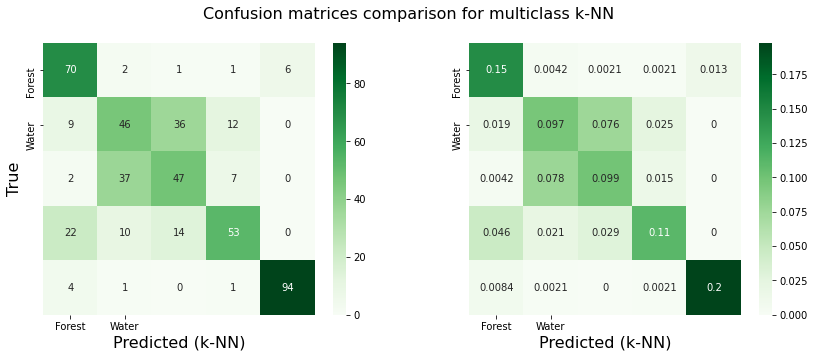

In [ ]:
# Initialize optimized k-NN classifier object. 
knn_classifier = KNeighborsClassifier(n_neighbors=15)
knn_classifier.fit(X_train, y_train.ravel())

# Have the newly trained classifier predict the classes of the withheld testing data.
knn_predicted = knn_classifier.predict(X_test)

## confusion matrix for k-NN
cfKNN = confusion_matrix(y_test, knn_predicted.ravel())
cfKNN_normalized = cfKNN/cfKNN.sum()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    cfKNN, cmap="Greens", annot=cfKNN, square=True, cbar=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted (k-NN)", fontsize=16)
ax[0].set_ylabel("True", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    cfKNN_normalized, cmap="Greens", annot=True, square=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted (k-NN)", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrices comparison for multiclass k-NN", fontsize=16)

# Display the figure.
fig.show()


The overall acurracy dropped significantly comparing to the binary results. When we take a closer look at the confusion matrix above, the corn and soy are mixed heavily by k-NN. This is understandable as we have seem in the feature space that they were quite hard to be separated based on our data.


## 6 - Activity  

Maybe you will ask can random forest help with the issue? It's a fun activity time for you to implement a random forest model for this multiclass classification problem. You should try to use a 10-fold cross validation strategy to figure out the best hyperparameter for your model. 


In [ ]:
## STEP 1 - Setting training control


## Step 2 - setting searching grid for your hyperparameter tuning


## Step 3 - inplement your cross validation training


## Step 4 - visualize your cross validation results


## Step 5 - report your final model performance


## Step 6 - Compare with the k-NN model result


